In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [34]:
df = pd.read_csv('price.csv')
df = df.loc[:, ['REF_DATE', 'GEO', 'Farm products', 'Category', 'CattleType', 'Product_Price']]

df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], format='%Y-%m-%d')


df['CattleType'] = df['CattleType'].fillna('None')

df['pct_change'] = df.groupby(['GEO', 'Farm products', 'Category', 'CattleType'])['Product_Price'].pct_change(12)

df = df.drop('Product_Price',axis= 1)

df = df.dropna(subset=['pct_change'])

C:\Users\boots\AppData\Local\Temp\ipykernel_36952\283169576.py:9: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['pct_change'] = df.groupby(['GEO', 'Farm products', 'Category', 'CattleType'])['Product_Price'].pct_change(12)


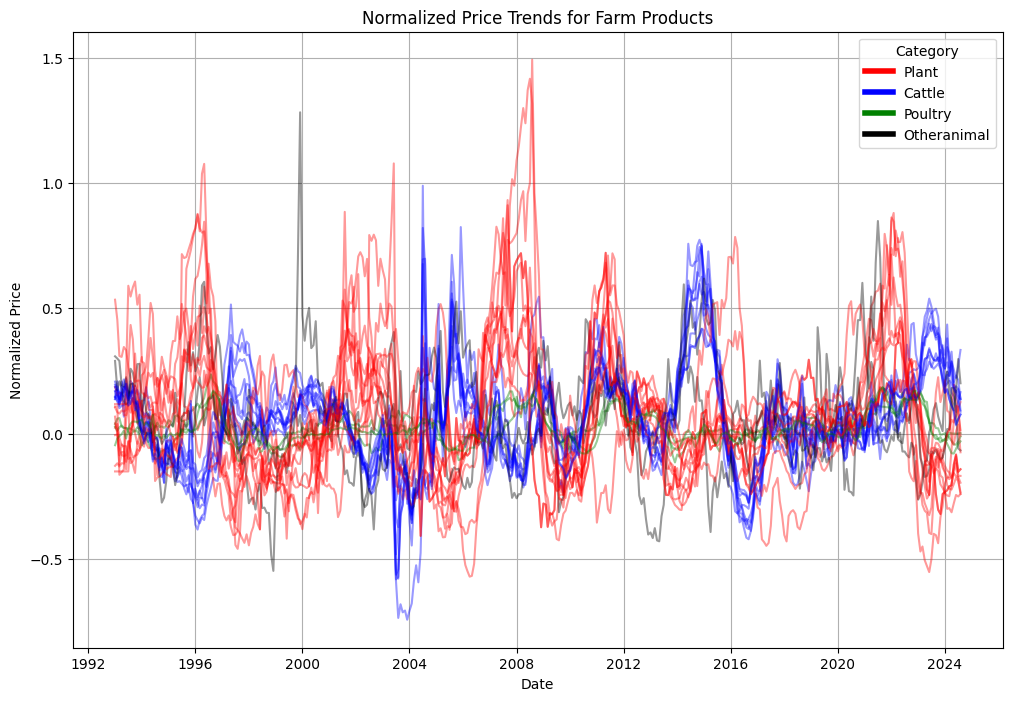

In [36]:
# Group data by relevant columns and calculate the mean Product Price
canada_wide_data = df.groupby(['REF_DATE', 'Farm products', 'Category', 'CattleType'])['pct_change'].mean().reset_index()

# Get the most recent price for each Farm product, Category, and CattleType
last_prices = canada_wide_data.groupby(['Farm products', 'Category', 'CattleType'])['pct_change'].last()

# Map the most recent price to each row in the canada_wide_data
canada_wide_data['Most Recent Price'] = [
    last_prices[(
        row['Farm products'],
        row['Category'],
        row['CattleType']
    )]
    for _, row in canada_wide_data.iterrows()
]

# Get unique combinations of Farm products, Category, and CattleType
categories = canada_wide_data[['Farm products', 'Category', 'CattleType']].drop_duplicates()

# Plotting normalized price trends
plt.figure(figsize=(12, 8))

# Define colors for each category
category_colors = {
    'plant': 'red',
    'cattle': 'blue',
    'poultry': 'green',
    'otheranimal': 'black'
}

# Loop through each unique category combination and plot the data
for i in range(categories.shape[0]):
    product = categories.iloc[i]['Farm products']
    category = categories.iloc[i]['Category']
    cattleType = categories.iloc[i]['CattleType']

    # Get color for the current category
    color = category_colors.get(category, 'black')

    # Filter data for the current combination
    product_data = canada_wide_data[
        (canada_wide_data['Farm products'] == product) & 
        (canada_wide_data['CattleType'] == cattleType)
    ]

    # Plot the normalized price trend
    plt.plot(product_data['REF_DATE'], product_data['pct_change'], label=product, alpha=0.4, color=color)

# Create custom legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=category.capitalize()) for category, color in category_colors.items()]

# Set plot title and labels
plt.title('Normalized Price Trends for Farm Products')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.grid(True)
plt.legend(handles=legend_elements, title="Category")  # Add custom legend to the plot
plt.show()

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['pct_change']] = scaler.fit_transform(df[['pct_change']])

data = df.pivot_table(index='REF_DATE', columns=['GEO', 'Farm products', 'Category', 'CattleType'], values = 'pct_change', aggfunc='first')

data = data.apply(lambda row: row.fillna(row.mean()), axis=1)

data.head()

C:\Users\boots\AppData\Local\Temp\ipykernel_36952\4183499223.py:9: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['pct_change'] = df.groupby(['GEO', 'Farm products', 'Category', 'CattleType'])['Product_Price'].pct_change(12)


GEO                    Alberta                            \
Farm products Barley [1151141]      Calves                 
Category                 plant      cattle                 
CattleType                None for_feeding for_slaughter   
REF_DATE                                                   
1993-01-01            0.210024    0.197852      0.200072   
1993-02-01            0.210496    0.201320      0.192797   
1993-03-01            0.209568    0.198979      0.212698   
1993-04-01            0.201961    0.202799      0.220274   
1993-05-01            0.191032    0.207257      0.193600   

GEO                                                                           \
Farm products Canola (including rapeseed) [113111]      Cattle                 
Category                                     plant      cattle                 
CattleType                                    None for_feeding for_slaughter   
REF_DATE                                                                       
1993-01-01                                0.209613    0.218728      0.221971   
1993-02-01                                0.208084    0.211795      0.222371   
1993-03-01                                0.207173    0.213148      0.211296   
1993-04-01                                0.207301    0.208177      0.206704   
1993-05-01                                0.198632    0.218635      0.213516   

GEO                                                                         \
Farm products Chickens for meat [11113131]          Cows Dry peas [114314]   
Category                           poultry        cattle             plant   
CattleType                            None for_slaughter              None   
REF_DATE                                                                     
1993-01-01                        0.176186      0.234859           0.21054   
1993-02-01                        0.181666      0.209707           0.21054   
1993-03-01                        0.181648      0.196955           0.21054   
1993-04-01                        0.184516      0.201949           0.21054   
1993-05-01                        0.178890      0.205170           0.21054   

GEO                                   ... Saskatchewan                \
Farm products Eggs in shell [116111]  ...      Heifers                 
Category                     poultry  ...       cattle                 
CattleType                      None  ...  for_feeding for_slaughter   
REF_DATE                              ...                              
1993-01-01                  0.183379  ...     0.219498      0.238076   
1993-02-01                  0.183427  ...     0.223885      0.217931   
1993-03-01                  0.185695  ...     0.220101      0.212462   
1993-04-01                  0.185769  ...     0.220500      0.206185   
1993-05-01                  0.178890  ...     0.229268      0.205437   

GEO                                                            \
Farm products Hogs [111121] Lambs [11114112] Lentils [114312]   
Category        otheranimal      otheranimal            plant   
CattleType             None             None             None   
REF_DATE                                                        
1993-01-01         0.246908         0.246018         0.146721   
1993-02-01         0.221199         0.266661         0.146721   
1993-03-01         0.237029         0.273356         0.146721   
1993-04-01         0.226242         0.221897         0.146721   
1993-05-01         0.210613         0.182757         0.146721   

GEO                                                       \
Farm products Oats [115113111]      Steers                 
Category                 plant      cattle                 
CattleType                None for_feeding for_slaughter   
REF_DATE                                                   
1993-01-01            0.215139    0.214809      0.231595   
1993-02-01            0.175587    0.219110      0.217503   
1993-03-01            0.1

In [25]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [26]:
SEQ_LENGTH = 10
X, y = create_sequences(data,  SEQ_LENGTH)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [27]:
X.shape

(370, 10, 178)

In [28]:
X_train

array([[[0.21002417, 0.197852  , 0.20007154, ..., 0.23159548,
         0.16878476, 0.20729484],
        [0.21049566, 0.20132038, 0.1927966 , ..., 0.21750304,
         0.17763473, 0.20464401],
        [0.20956801, 0.19897862, 0.21269847, ..., 0.21582794,
         0.17386766, 0.19827774],
        ...,
        [0.1672537 , 0.21391685, 0.22305382, ..., 0.22275005,
         0.18556622, 0.20149584],
        [0.14414576, 0.22916018, 0.2297249 , ..., 0.22953421,
         0.186851  , 0.20155961],
        [0.14466063, 0.24862483, 0.22135511, ..., 0.19360532,
         0.18419747, 0.19794098]],

       [[0.21049566, 0.20132038, 0.1927966 , ..., 0.21750304,
         0.17763473, 0.20464401],
        [0.20956801, 0.19897862, 0.21269847, ..., 0.21582794,
         0.17386766, 0.19827774],
        [0.20196103, 0.20279883, 0.22027402, ..., 0.19967521,
         0.17126552, 0.19966568],
        ...,
        [0.14414576, 0.22916018, 0.2297249 , ..., 0.22953421,
         0.186851  , 0.20155961],
        [0.1

In [29]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(LSTM(50))
model.add(Dense(X.shape[2]))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\boots\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0331 - val_loss: 0.0204
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0171 - val_loss: 0.0089
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0018
E

In [31]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011     
Test Loss: 0.0012858158443123102


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


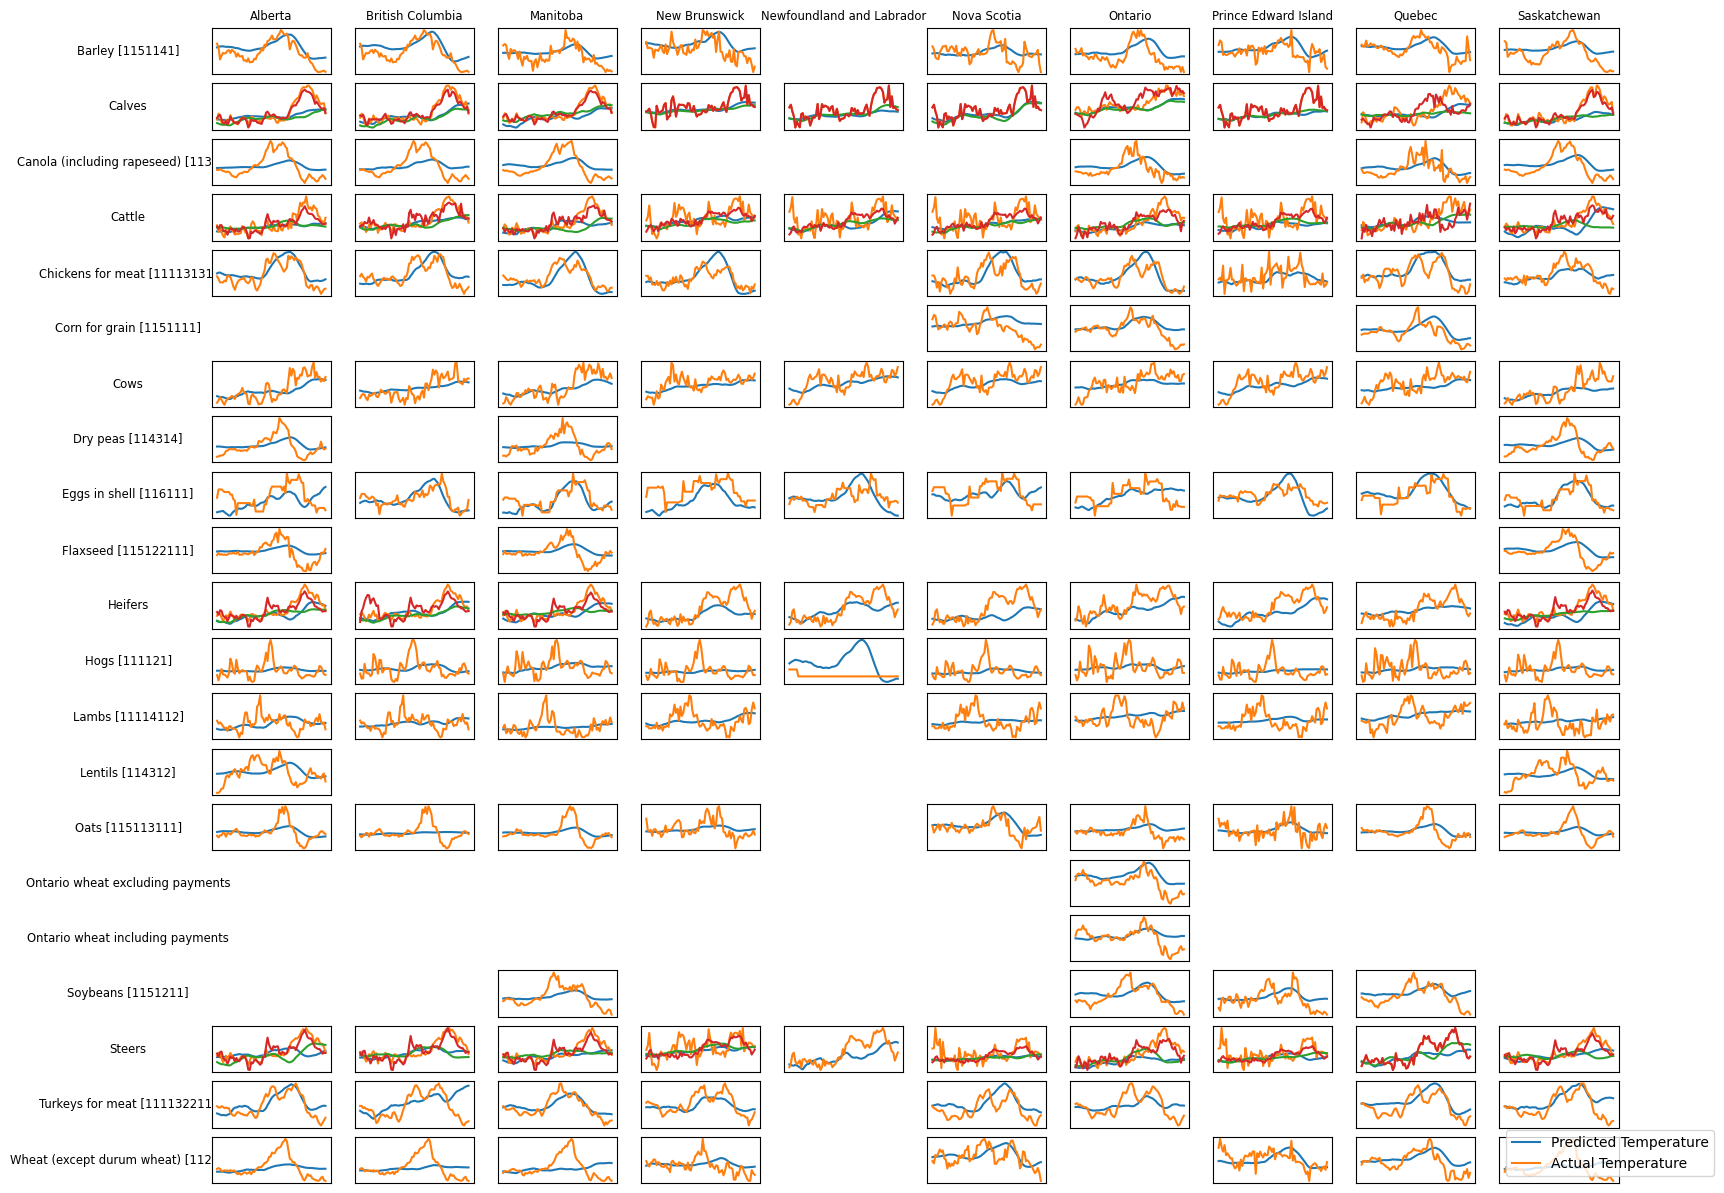

In [32]:
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test)

products = np.unique( [c[1] for c in data.columns] )
provinces = np.unique( [c[0] for c in data.columns] )

# Plot the results
import matplotlib.pyplot as plt
#plt.figure(figsize=(21, 15))

fig, axes = plt.subplots(nrows=21, ncols=11, figsize=(20, 15))

for i in range(21):
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    for j in range(0, 11):
        axes[i, j].axis('off')

for i in range(predictions.shape[1]):
    r = np.where(products == data.columns[i][1])[0][0]
    c = np.where(provinces == data.columns[i][0])[0][0] + 1

    axes[r, c].axis('on')

    axes[r, c].plot(predictions[:, i], label='Predicted Temperature')
    axes[r, c].plot(y_test_scaled[:, i], label='Actual Temperature')

    # Optional: Remove the x and y ticks for clarity
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

for j, col in enumerate(provinces):
    axes[0, j+1].set_title(col, size = 'small')

for ax, row in zip(axes[:,0], products):   
    ax.text(0.5, 0.5, row, ha='center', va='center', rotation=0, size='small')
    ax.axis('off')  # Turn off the axis for the label cells

#plt.tight_layout()
plt.legend()
plt.show()